# Downloading SAMOS data from MarineFlux ERDDAP server

In [71]:
from erddapy import ERDDAP
import matplotlib.pyplot as plt
import numpy as np
import cf_xarray

## Create the ERDDAP request

In [72]:
flux_algorithms = ["S88", "B23", "C36"]
vars = ['hfss', 'hfss_qc', 'hfls', 'hfls_qc', 'tau', 'tau_qc', 'u_10', 'u_10_qc', 't_10', 't_10_qc', 'q_10', 'q_10_qc', 'C_d', 'C_d_qc', 'C_h', 'C_h_qc', 'C_e', 'C_e_qc', 'z_over_L', 'zo_m', 'u_star', 't_star', 'q_star', 'sst_adj']
start_time = "2021-01-01T00:00:00Z"
end_time = "2021-02-01T00:00:00Z"

In [73]:
erddap_samos = dict()
for algo in flux_algorithms:
  erddap_samos[algo] = ERDDAP(
    server="http://erddap-samos-dev.coaps.fsu.edu/erddap",
    protocol="tabledap",
  )

  erddap_samos[algo].dataset_id = f"SAMOS_Fluxes_{algo}_TEST"
  # erddap_samos[algo].constraints = {
  #     "time>=": start_time,
  #     "time<=": end_time,
  # }
  erddap_samos[algo].variables = vars

## Request data as xarray Dataset

In [74]:
ds = dict()

for algo in flux_algorithms:
    ds[algo] = erddap_samos[algo].to_xarray()

    print(ds[algo])

<xarray.Dataset>
Dimensions:    (row: 20576)
Coordinates:
    longitude  (row) float32 ...
    latitude   (row) float32 ...
    time       (row) datetime64[ns] ...
Dimensions without coordinates: row
Data variables: (12/24)
    hfss       (row) float64 ...
    hfss_qc    (row) float32 ...
    hfls       (row) float64 ...
    hfls_qc    (row) float32 ...
    tau        (row) float64 ...
    tau_qc     (row) float32 ...
    ...         ...
    z_over_L   (row) float64 ...
    zo_m       (row) float64 ...
    u_star     (row) float64 ...
    t_star     (row) float64 ...
    q_star     (row) float64 ...
    sst_adj    (row) float64 ...
Attributes: (12/39)
    acknowledgement:           NOAA/CPO/COM via award NA21OAR4310262
    cdm_data_type:             Point
    comment:                   These data are all of the input variables and ...
    Conventions:               COARDS, CF-1.6, ACDD-1.3
    creator_name:              Marine Data Center, Center for Ocean-Atmospher...
    creator_type

### Create histograms

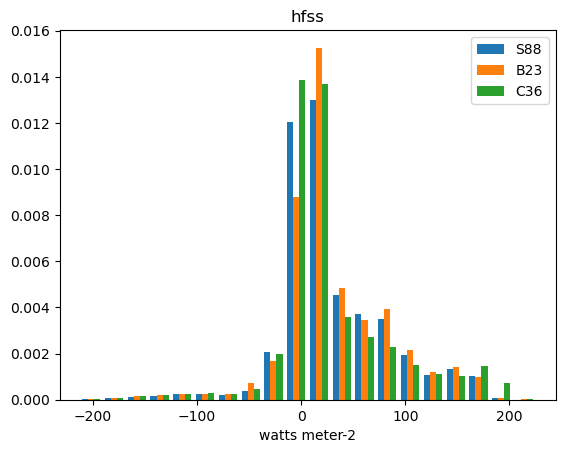

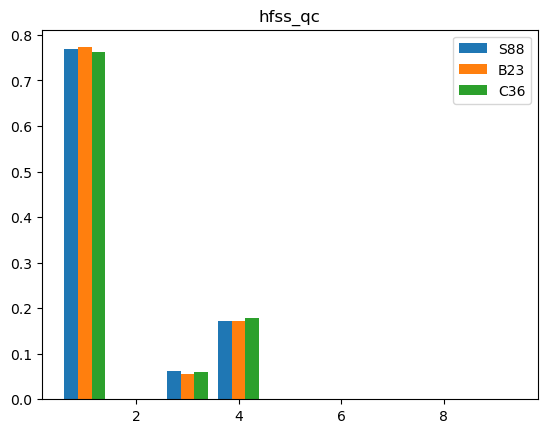

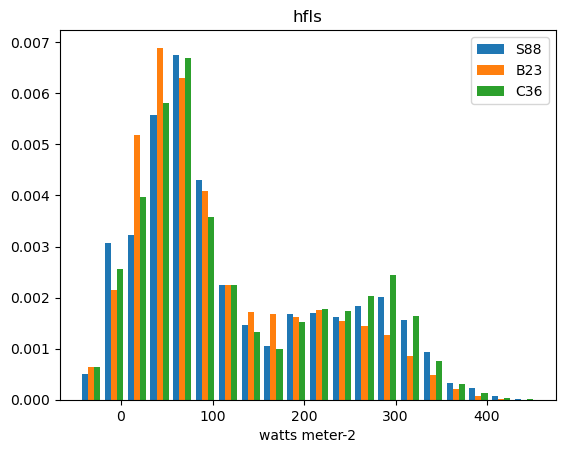

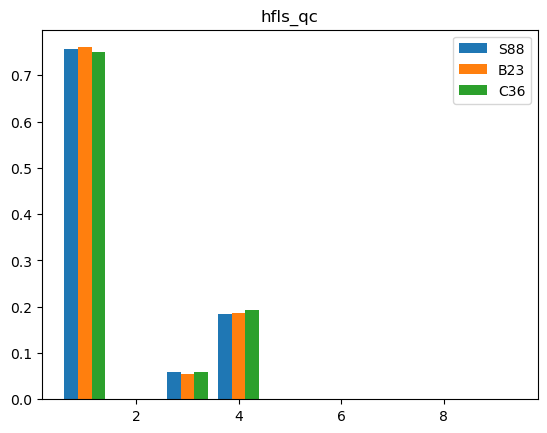

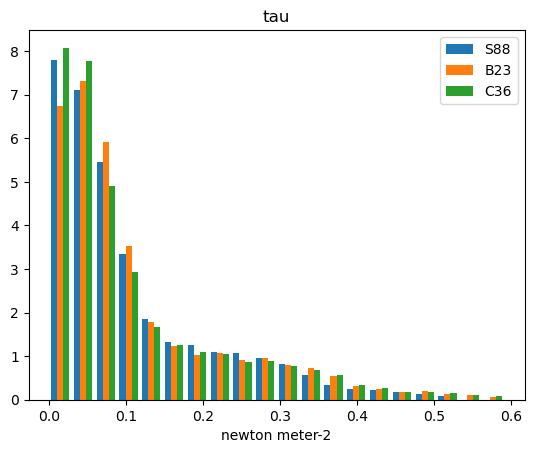

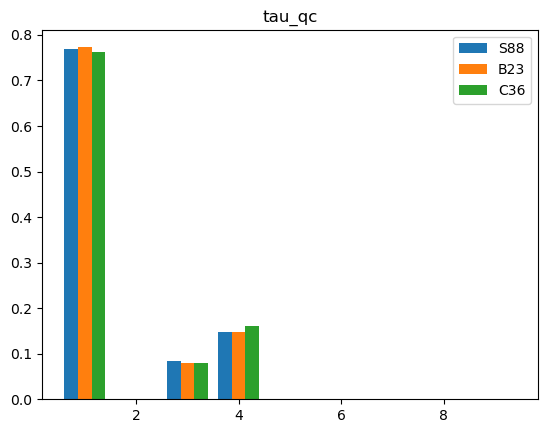

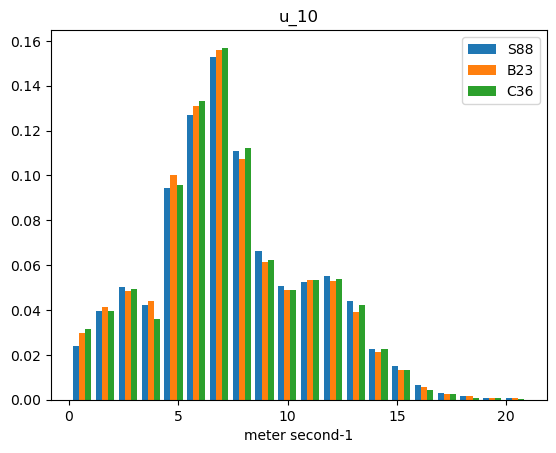

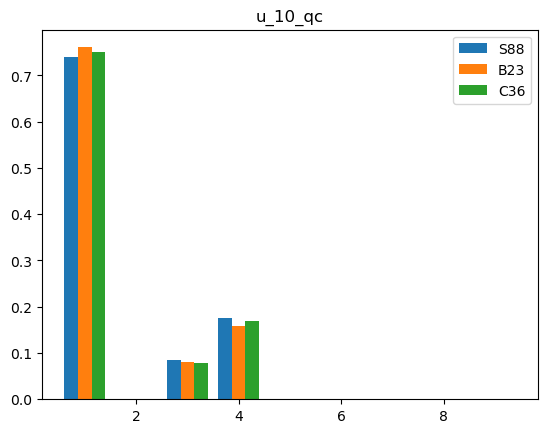

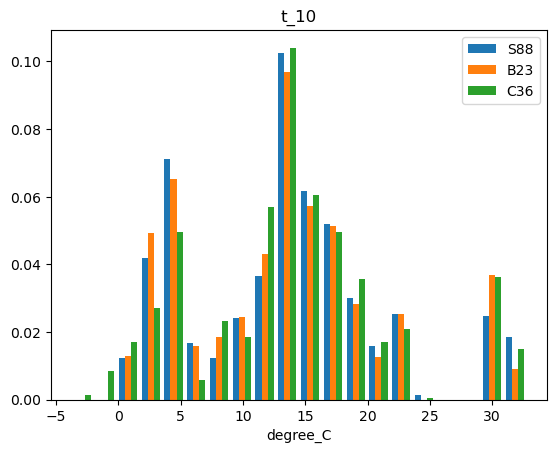

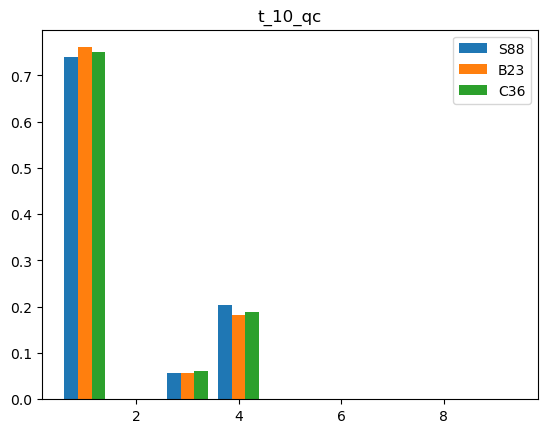

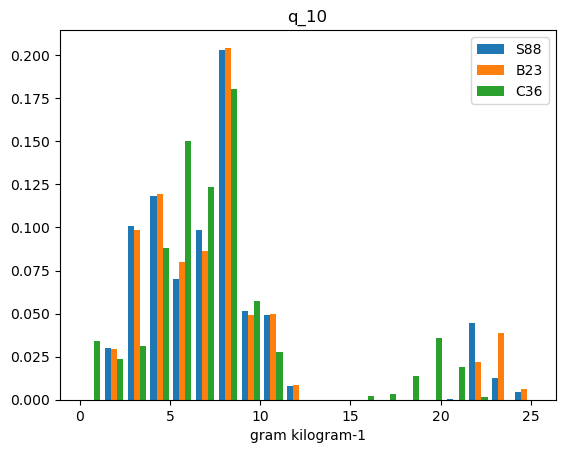

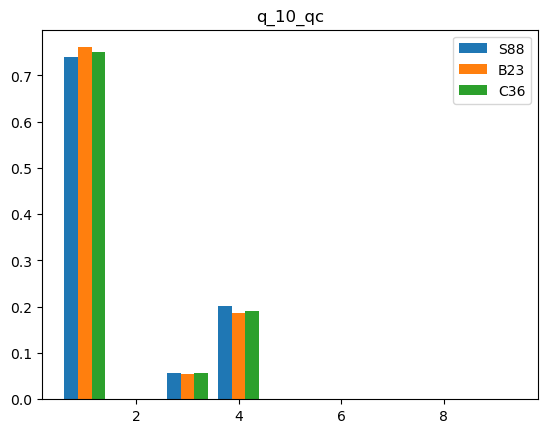

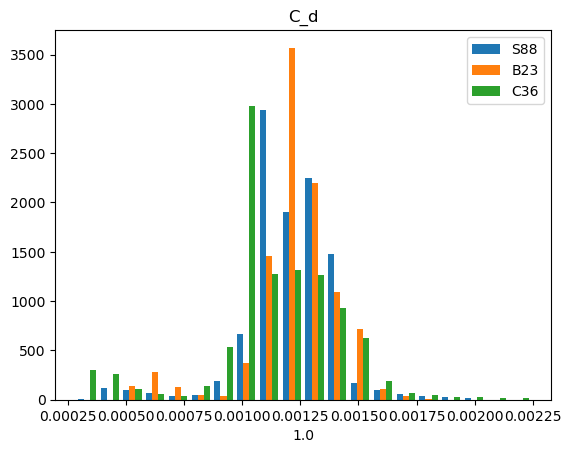

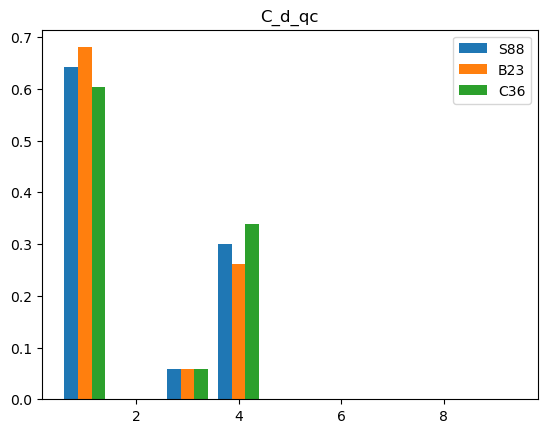

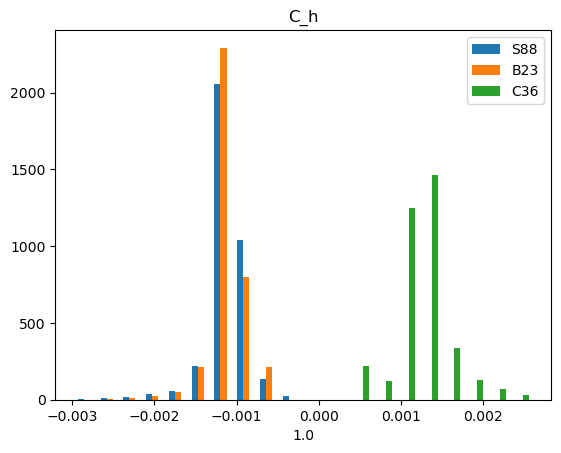

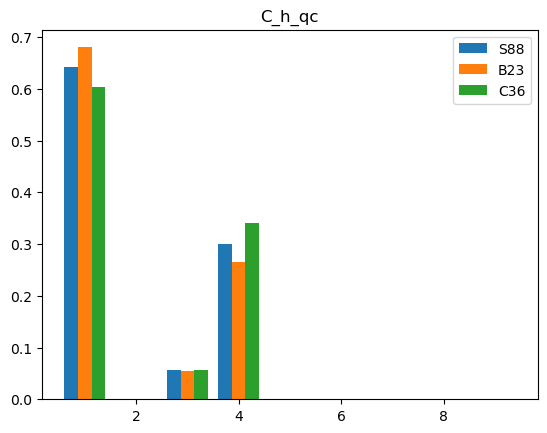

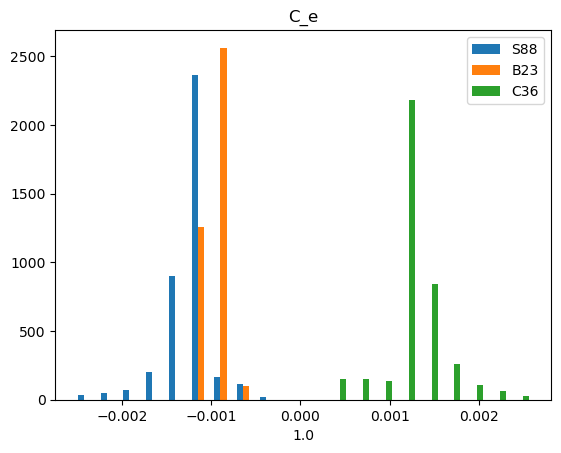

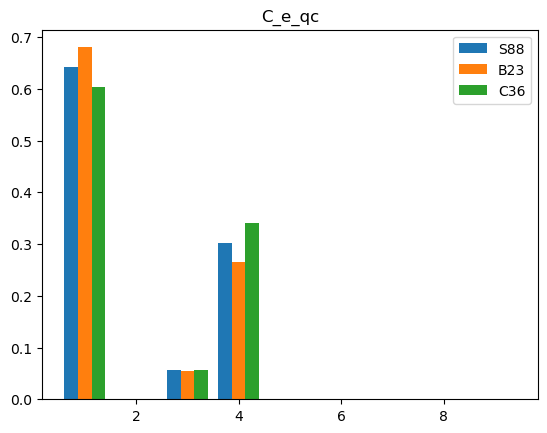

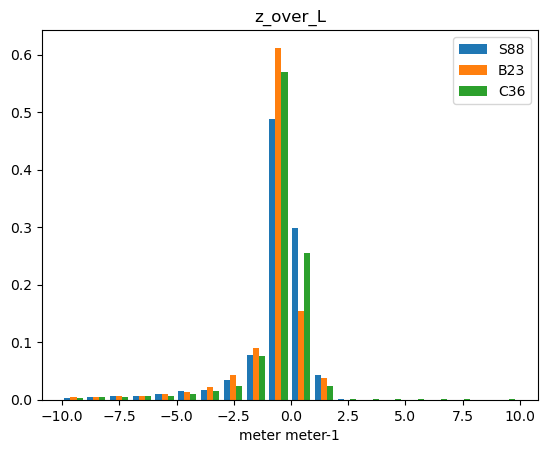

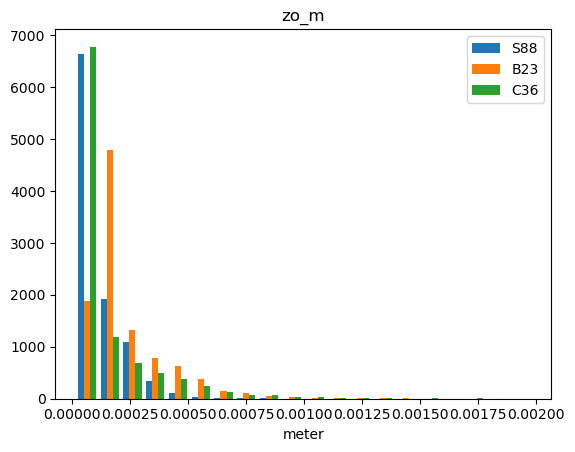

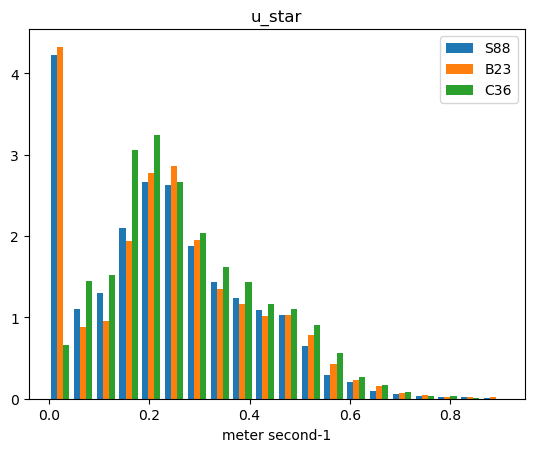

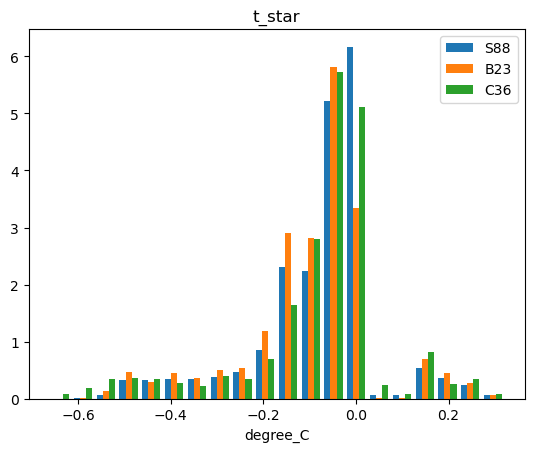

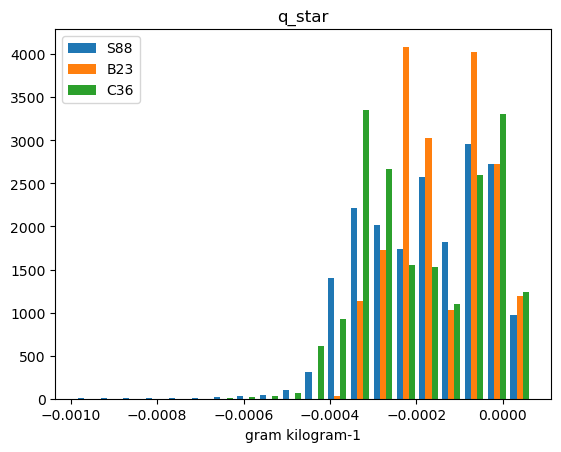

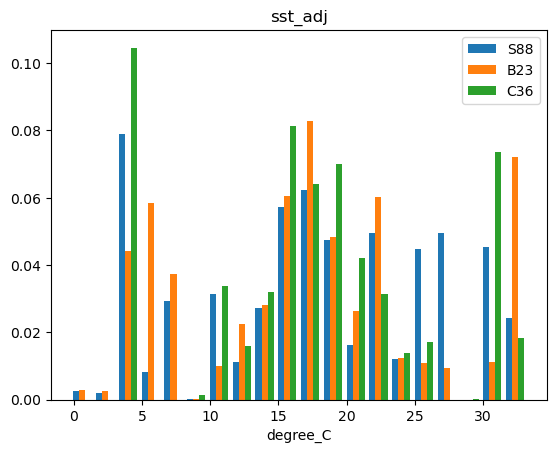

In [75]:
for var in vars:
    y = []
    for algo in flux_algorithms:

        data = ds[algo][var].data
        data[data==-9999.0] = np.nan
        data[data==-8888.0] = np.nan

        if f'{var}_qc' in ds[algo]:
            good_indices = np.where((ds[algo][f'{var}_qc'].cf == 'good') == True)[0]
            mask = np.zeros(len(data), dtype=bool)
            mask[good_indices] = True
            masked_data = data[mask]
            data = masked_data

        median = np.nanmedian(data)
        std = np.nanstd(data)
        lower_limit = median - (4 * std)
        upper_limit = median + (4 * std)

        if var == 'z_over_L':
            lower_limit = -10
            upper_limit = 10
        elif var == 'q_10':
            lower_limit = 0
            upper_limit = 40
        elif var == 'q_star':
            lower_limit = -0.001
            upper_limit = 0.001
        elif var == 'zo_m':
            lower_limit = 0
            upper_limit = 0.002
        
        data[data<lower_limit] = np.nan
        data[data>upper_limit] = np.nan

        y.append(data)

    if '_qc' in var:
        bins = [0.5, 1.5, 2.5, 3.5, 4.5, 8.5, 9.5]
        range = (0, 10)
    else:
        bins = 20
        range = None

    plt.hist(y, bins=bins, range=range, density=True, label=['S88', 'B23', 'C36'])
    if 'units' in ds['S88'][var].attrs:
        plt.xlabel(ds['S88'][var].units)

    plt.title(f'{var}')
    plt.legend()
    plt.show()